In [5]:
import argparse
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from sklearn.decomposition import PCA

2025-05-09 22:35:24.442635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746855324.717012 2236494 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746855324.793324 2236494 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746855325.476685 2236494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746855325.476701 2236494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746855325.476703 2236494 computation_placer.cc:177] computation placer alr

# Define model architecture and components

In [6]:
#Class def for sampler
class Sampling(layers.Layer): #Sampler
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAEReconLoss(tf.keras.losses.Loss):
    def call(self, inputs, reconstruction):
        x= inputs
        eps= 1e-7
        feature_dim= tf.cast(tf.shape(x)[1], tf.float32)
        bce= keras.losses.binary_crossentropy(x, tf.clip_by_value(reconstruction, eps, 1-eps))
        return tf.reduce_mean(bce)  * feature_dim

class VAEKLLoss(tf.keras.losses.Loss):
    def call(self, z_mean, z_log_var):
            z_log_var= tf.clip_by_value(z_log_var, -10.0, 10.0)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var+ 1e-8))
            kl_loss= tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            return kl_loss
        
#Load and split data across jobs
def load_split_data():
    rnaseq_df= pd.read_csv('/home1/andreav6/QBIO465/Top10kVar/top10kvar_counts_minmax.csv', index_col=0)
    survival_condition= pd.read_csv('/home1/andreav6/QBIO465/Top10kVar/clinical_survival_label_filtered_405.csv', index_col=0)
    X = rnaseq_df.astype(np.float32)
    y= survival_condition.astype(np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
    input_shape= (X.shape[1],) #Adding 1 for condition label
    return (X_train, y_train), (X_test, y_test), input_shape

def load_data_full():
    rnaseq_df= pd.read_csv('/home1/andreav6/QBIO465/Top10kVar/top10kvar_counts_minmax.csv', index_col=0)
    survival_condition= pd.read_csv('/home1/andreav6/QBIO465/Top10kVar/clinical_survival_label_filtered_405.csv', index_col=0)
    X = rnaseq_df.astype(np.float32)
    y= survival_condition.astype(np.float32)
    input_shape= (X.shape[1], )
    return X, y, input_shape

# Build VAE model
def build_cvae(hp, latent_dim, input_shape):
    condition_dim= 1 #Just using survival status for now
    total_input_dim= input_shape[0]

    #Encoder
    encoder_input = keras.Input(shape=input_shape)
    x = encoder_input
    conv_filters = [] #Empty list to save hps tried and order from encoder for  to work

    for i in range(hp.Int("num_conv_layers", 1, 4)):
        filters = hp.Int(f"units_{i}", 128, 512, step=64)
        conv_filters.append(filters)
        x = layers.Dense(filters, activation='relu')(x)

    # x = layers.Flatten()(x)
    # x = layers.Dense(hp.Choice("dense_units", [64, 128]), activation=None)(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var]) #Latent space
    encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

    decoder_input = keras.Input(shape=(latent_dim + condition_dim,))
    x= decoder_input
    for i, filters in reversed(list(enumerate(conv_filters))): #Use list of filters reversed
        x = layers.Dense(filters, activation='relu')(x)
    decoder_output = layers.Dense(total_input_dim-1, activation='sigmoid')(x)
    decoder = keras.Model(decoder_input, decoder_output, name='decoder')

    class CVAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.recon_loss_fn = VAEReconLoss()
            self.kl_loss_fn = VAEKLLoss()

            self.total_loss_tracker=keras.metrics.Mean(name="loss")
            self.reconstruction_loss_tracker= keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker= keras.metrics.Mean(name="kl_loss")


        def call(self, inputs):
            x, c = inputs[:, :-1], inputs[:, -1:]
            enc_input= tf.concat([x, c], axis=1)
            z_mean, z_log_var, z = self.encoder(enc_input)
            # Ensure they're not None
            if z_mean is None or z_log_var is None:
                raise ValueError("z_mean or z_log_var is None!")
            
            dec_input= tf.concat([z, c], axis=1)
            reconstruction = self.decoder(dec_input)
            return reconstruction
        
        @property
        def metrics(self):
            return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                x, c = data[:, :-1], data[:, -1:]
                enc_input= tf.concat([x, c], axis=1)
                z_mean, z_log_var, z = self.encoder(enc_input)
                dec_input= tf.concat([z, c], axis=1)
                reconstruction = self.decoder(dec_input)
                recon_loss = self.recon_loss_fn(x, reconstruction)
                kl_loss = self.kl_loss_fn(z_mean, z_log_var)
                total_loss= recon_loss + kl_loss
            grads= tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(recon_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss" : self.total_loss_tracker.result(),
                "reconstruction loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),}
            
        def test_step(self, data):
            x, c = data[:, :-1], data[:, -1:]
            enc_input= tf.concat([x, c], axis=1)
            z_mean, z_log_var, z = self.encoder(enc_input)
            dec_input= tf.concat([z, c], axis=1)
            reconstruction = self.decoder(dec_input)
            recon_loss = self.recon_loss_fn(x, reconstruction)
            kl_loss = self.kl_loss_fn(z_mean, z_log_var)
            total_loss= recon_loss + kl_loss
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(recon_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss" : self.total_loss_tracker.result(),
                "reconstruction loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),}  


    model = CVAE(encoder, decoder)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])), metrics=[])
    _= model(tf.zeros((1, input_shape[0])))
    return model

def save_reconstructions(model, X_test, y_test, latent_dim, job_id):
    recon = model.predict(X_test_cond[:10])
    originals = X_test_cond[:10, :-1]
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axs[0, i].imshow(originals[i].reshape(1, -1), aspect='auto', cmap='viridis')
        axs[0, i].axis('off')
        axs[1, i].imshow(recon[i].reshape(1, -1), aspect='auto', cmap='viridis')
        axs[1, i].axis('off')
    plt.suptitle('Top: Original, Bottom: Reconstructed')
    plt.savefig(f'reconstructions_latent{latent_dim}_job{job_id}.png')
    plt.close()


In [24]:
(X_train, y_train), (X_test, y_test), input_shape = load_split_data()

X_train_cond= np.hstack([X_train, y_train])
X_test_cond= np.hstack([X_test, y_test])
input_shape=(X_train_cond.shape[1], )
cmap=plt.get_cmap("Paired")

# Tuner for 16 latent dimensions

In [21]:
tuner_16 = kt.BayesianOptimization(lambda hp: build_cvae(hp, 16, input_shape),
        objective='val_loss',
        max_trials=50,
        executions_per_trial=5,
        overwrite=False,
        directory='./model_tuning_training/tunning_trials',
        project_name='cvae_latent16_final_tunning')

Reloading Tuner from ./model_tuning_training/tunning_trials/cvae_latent16_final_tunning/tuner0.json


In [6]:
tuner_16.search(X_train_cond,
                 epochs=100,
                 batch_size=128,
                 validation_split=0.2,
                 callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - kl_loss: nan - loss: nan - reconstruction loss: nan - val_kl_loss: nan - val_loss: nan - val_reconstruction loss: nan
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: nan - loss: nan - reconstruction loss: nan - val_kl_loss: nan - val_loss: nan - val_reconstruction loss: nan
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: nan - loss: nan - reconstruction loss: nan - val_kl_loss: nan - val_loss: nan - val_reconstruction loss: nan
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - kl_loss: nan - loss: nan - reconstruction loss: nan - val_kl_loss: nan - val_loss: nan - val_reconstruction loss: nan
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - kl_loss: nan - loss: nan - reconstruction loss: nan - val_kl_loss: nan - val_loss: nan - val_reconstruction loss: nan
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: nan - loss: nan - reconstruction loss: nan - val_kl_loss: nan - val_loss: nan - val_reco

RuntimeError: Number of consecutive failures exceeded the limit of 3.


In [22]:
best_hps= tuner_16.get_best_hyperparameters(1)[0]
best_model= build_cvae(best_hps, 16, input_shape)
best_model.build(input_shape= input_shape)
hist= best_model.fit(X_train_cond, 
                     epochs=100, 
                     batch_size=128, 
                     validation_data=X_test_cond)
best_model.save('best_model_latent16_final.keras')
hist_df = pd.DataFrame(hist.history)

hist_df.to_csv('training_hist_best_model_latent16_final.csv')


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - kl_loss: 158.3667 - loss: 6237.7275 - reconstruction loss: 6079.3599 - val_kl_loss: 266.8495 - val_loss: 8720.2480 - val_reconstruction loss: 8453.3984
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - kl_loss: 204.6942 - loss: 6764.0181 - reconstruction loss: 6559.3232 - val_kl_loss: 158.0984 - val_loss: 5229.8809 - val_reconstruction loss: 5071.7822
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - kl_loss: 149.1302 - loss: 5182.2461 - reconstruction loss: 5033.1162 - val_kl_loss: 134.9083 - val_loss: 5168.9185 - val_reconstruction loss: 5034.0103
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - kl_loss: 93.0149 - loss: 4905.3516 - reconstruction loss: 4812.3369 - val_kl_loss: 56.4920 - val_loss: 4863.5161 - val_reconstruction loss: 4807.0239
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - kl_loss: 38.5375 - loss: 4718.0420 - reconstruction loss: 4679.5044 - val_kl_loss: 11.4182 - val_loss: 4614.3491 - val_reconstruction

In [70]:
# Get (z_mean, z_log_var, z_sampled)
reconstructions_testing_16 = best_model.encoder.predict(X_test_cond)
z_sampled = reconstructions_testing[2]  # Shape: (batch_size, latent_dim)
condition_vectors = X_test_cond[:, -1:]  # assuming the condition is the last column
decoder_input = np.concatenate([z_sampled, condition_vectors], axis=1)  # Shape: (batch_size, latent_dim + cond_dim)
augmented_16 = best_model.decoder.predict(decoder_input)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [75]:
z_sampled_16_df= pd.DataFrame(z_sampled)
augmented_16_df= pd.DataFrame(augmented_16)
z_sampled_16_df.to_csv('latent_vectors_testing_16.csv')
augmented_16_df.to_csv("augmented_data_16_testing.csv")

In [8]:
z_sampled_16_df= pd.read_csv("latent_vectors_testing_16.csv")
augmented_16_df= pd.read_csv("augmented_data_16_testing.csv")

# Tuner for 32 latent dimensions

In [5]:
tuner_32 = kt.BayesianOptimization(lambda hp: build_cvae(hp, 32, input_shape),
        objective='val_loss',
        max_trials=50,
        executions_per_trial=5,
        overwrite=False,
        directory='./model_tuning_training/tunning_trials',
        project_name='cvae_latent32_final_tunning')

Reloading Tuner from ./model_tuning_training/tunning_trials/cvae_latent32_final_tunning/tuner0.json


In [6]:
tuner_32.search(X_train_cond,
                 epochs=100,
                 batch_size=128,
                 validation_split=0.2,
                 callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

Trial 34 Complete [00h 02m 06s]
val_loss: 4105.94287109375

Best val_loss So Far: 4081.80400390625
Total elapsed time: 01h 15m 10s

Search: Running Trial #35

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_conv_layers
512               |256               |units_0
0.001             |0.001             |lr
512               |448               |units_1
512               |384               |units_2
128               |128               |units_3

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - kl_loss: 48.0810 - loss: 6776.6313 - reconstruction loss: 6728.5508 - val_kl_loss: 229.1142 - val_loss: 5563.0391 - val_reconstruction loss: 5333.9248
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step - kl_loss: 236.7998 - loss: 5346.0107 - reconstruction loss: 5109.2109 - val_kl_loss: 165.7645 - val_loss: 5125.2461 - val_reconstruction loss: 4959.4814
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - kl_loss: 136.3825 - loss: 5055.8071 - reconstr

KeyboardInterrupt: 

In [77]:
# Get (z_mean, z_log_var, z_sampled)
reconstructions_testing_32 = best_model_32.encoder.predict(X_test_cond)
z_sampled_32 = reconstructions_testing_32[2]  # Shape: (batch_size, latent_dim)
condition_vectors_32 = X_test_cond[:, -1:]  # assuming the condition is the last column
decoder_input_32 = np.concatenate([z_sampled_32, condition_vectors_32], axis=1)  # Shape: (batch_size, latent_dim + cond_dim)
augmented_32 = best_model_32.decoder.predict(decoder_input_32)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [79]:
z_sampled_32_df= pd.DataFrame(z_sampled_32)
z_sampled_32_df.to_csv('latent_vectors_32_testing.csv')
augmented_32_df= pd.DataFrame(augmented_32)
augmented_32_df.to_csv("augmented_32_testing.csv")

In [9]:
z_sampled_32_df= pd.read_csv('latent_vectors_32_testing.csv')
augmented_32_df= pd.read_csv("augmented_32_testing.csv")

# Comparing model training and performance

Text(0.5, 0.98, 'Model loss throughout training')

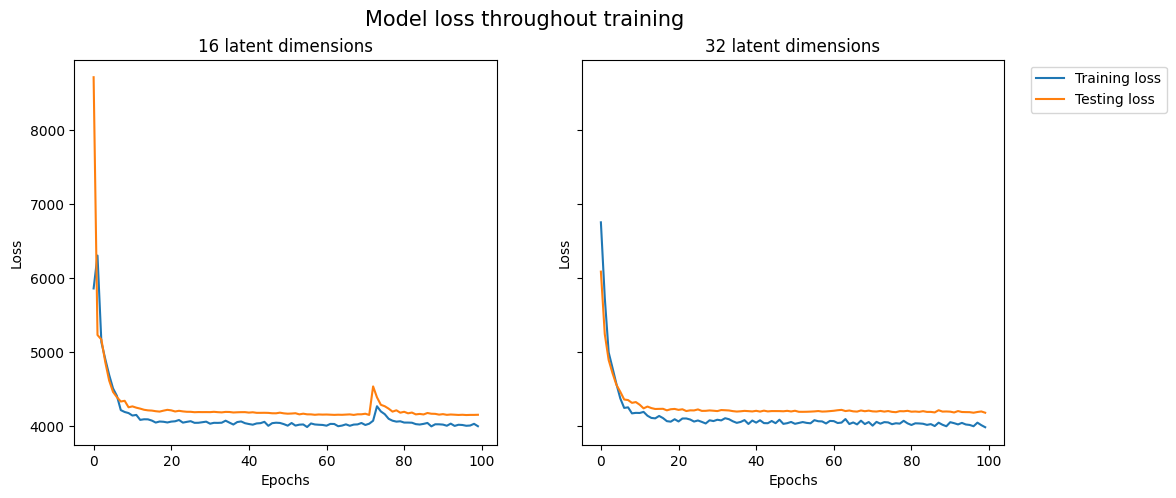

In [97]:
hist_df= pd.read_csv('training_hist_best_model_latent16_final.csv')
hist_32_df= pd.read_csv('training_hist_best_model_latent32_final.csv')
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

axs[0].plot(hist_df['loss'], label="Training loss")
axs[0].plot(hist_df['val_loss'], label="Validation loss")
axs[0].set_title("16 latent dimensions")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(hist_32_df['loss'], label='Training loss')
axs[1].plot(hist_32_df['val_loss'], label='Testing loss')
axs[1].set_title("32 latent dimensions")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")

plt.legend(bbox_to_anchor=(1.4, 1))
fig.suptitle("Model loss throughout training", fontsize=15)

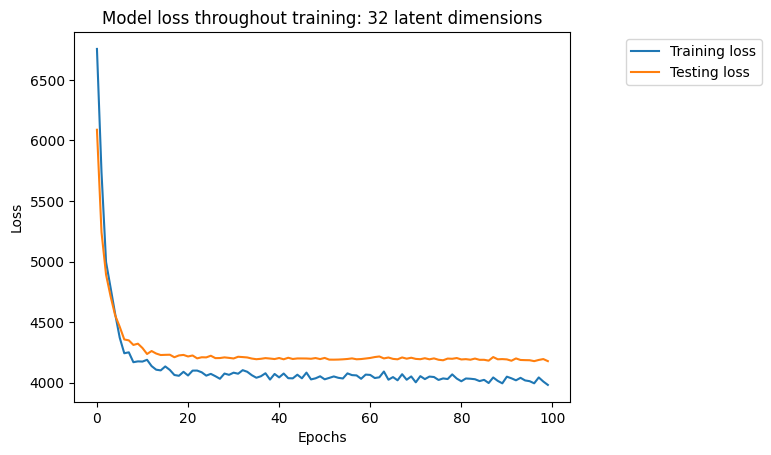

In [41]:
hist_32_df= pd.read_csv("training_hist_best_model_latent32_final.csv")
plt.plot(hist_32_df['loss'], label='Training loss')
plt.plot(hist_32_df['val_loss'], label='Testing loss')
plt.title("Model loss throughout training: 32 latent dimensions")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend(bbox_to_anchor=(1.4, 1))


In [14]:
X_test_cond_df= pd.DataFrame(X_test_cond)
#X_test_cond_df.to_csv("testing_labels.csv") #Exporting labels for testing set --> labels hosul correspond to the augmented data profiles

# Visualizing the latent space

In [116]:
encoded_test= best_model.encoder.predict(X_test_cond)
pca_recon= PCA(n_components=2)
pca_recon= pca_recon.fit_transform(z_sampled_16_df)
y_test['color']= y_test['vital_status'].map({0.0: cmap.colors[2], 1.0: cmap.colors[4]})
encoded_training= best_model.encoder.predict(X_train_cond)
pca_encoded_train= PCA(n_components=2)
pca_encoded_train= pca_encoded_train.fit_transform(X_train_cond)
y_train['color']= y_train['vital_status'].map({0.0: cmap.colors[3], 1.0: cmap.colors[5]})

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


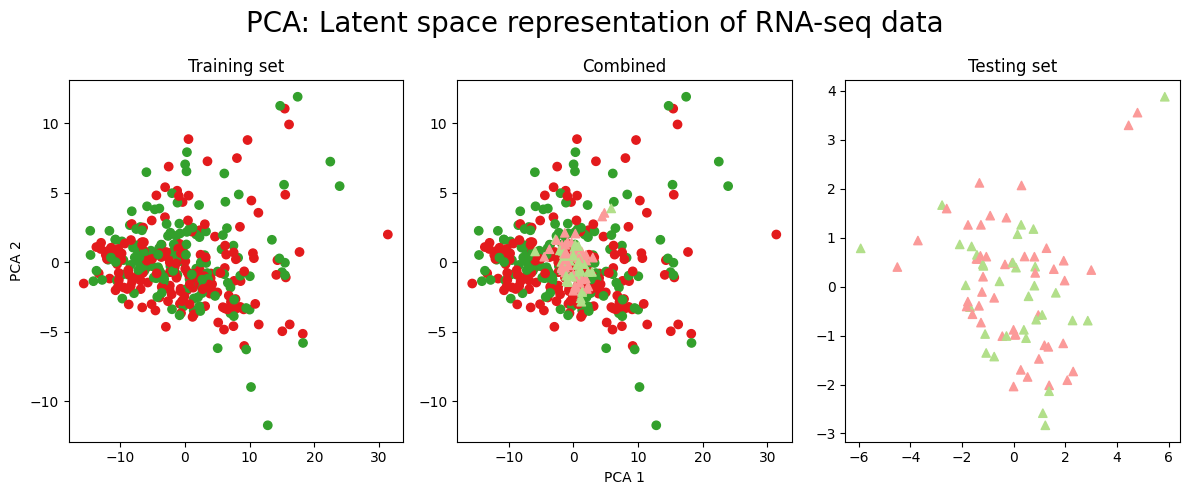

In [118]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 2 columns
axs[0].scatter(pca_recon_train[:, 0], pca_recon_train[:, 1], color=y_train['color'], marker='o')
axs[0].set_ylabel("PCA 2")
axs[0].set_title("Training set")
axs[1].scatter(pca_recon_train[:, 0], pca_recon_train[:, 1], color=y_train['color'], marker='o')
axs[1].scatter(pca_recon[:, 0], pca_recon[:, 1], color=y_test['color'], label='testing reconstructions', marker='^')
axs[1].set_xlabel("PCA 1")
axs[1].set_title("Combined")
axs[2].scatter(pca_recon[:, 0], pca_recon[:, 1], color=y_test['color'], label='testing reconstructions', marker='^')
axs[2].set_title("Testing set")
fig.suptitle("PCA: Latent space representation of RNA-seq data", fontsize=20)
plt.tight_layout()

# Comparing generated profiles to real profiles

In [22]:
real_data_alive= X_test_cond_df[X_test_cond_df.iloc[:, -1]== 0]
augmented_data_alive= augmented_32_df.loc[real_data_alive.index]
labels = np.array([1]*33 + [0]*33)

In [28]:
real_data_dead= X_test_cond_df[X_test_cond_df.iloc[:, -1]== 1]
augmented_data_dead= augmented_32_df.loc[real_data_dead.index]
labels_dead = np.array([1]*33 + [0]*33)

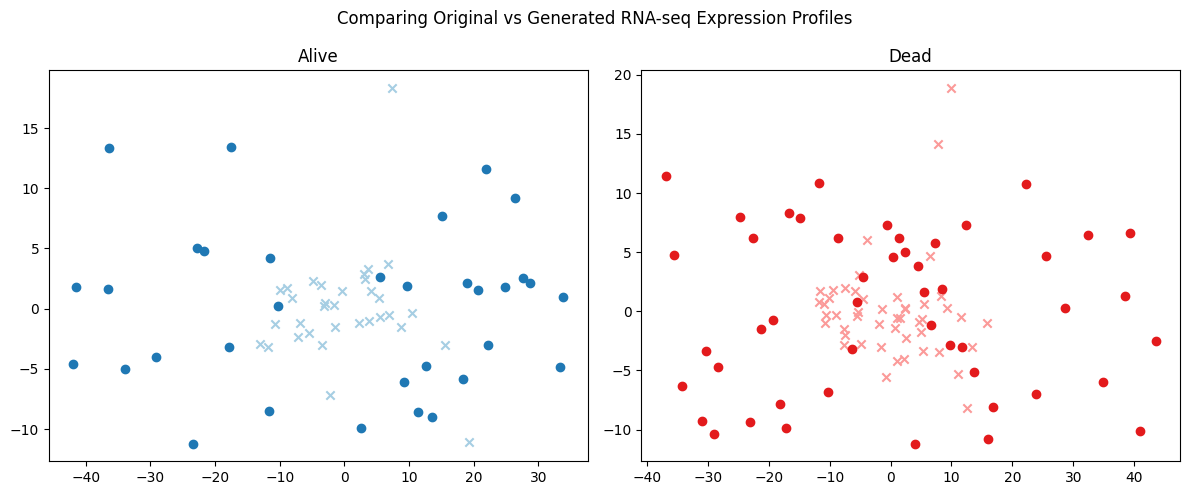

In [34]:
PCA_real_space= PCA(n_components=2)
PCA_real_space= PCA_real_space.fit_transform(real_data_alive)
PCA_augmented= PCA(n_components=2)
PCA_augmented= PCA_augmented.fit_transform(augmented_data_alive)


PCA_real_space_dead= PCA(n_components=2)
PCA_real_space_dead= PCA_real_space_dead.fit_transform(real_data_dead)
PCA_augmented_dead= PCA(n_components=2)
PCA_augmented_dead= PCA_augmented_dead.fit_transform(augmented_data_dead)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axs[0].scatter(PCA_real_space[:, 0], PCA_real_space[:, 1], marker='x', label="Original TCGA RNA-seq profiles", color=cmap.colors[0])
axs[0].scatter(PCA_augmented[:, 0], PCA_augmented[:, 1], marker='o', label="Augmented TCGA RNA-seq profiles", color=cmap.colors[1])
axs[0].set_title("Alive")
axs[1].set_title("Dead")
axs[1].scatter(PCA_real_space_dead[:, 0], PCA_real_space_dead[:, 1], marker='x', label="Original TCGA RNA-seq profiles", color=cmap.colors[4])
axs[1].scatter(PCA_augmented_dead[:, 0], PCA_augmented_dead[:, 1], marker='o', label="Augmented TCGA RNA-seq profiles", color=cmap.colors[5])
fig.suptitle("Comparing Original vs Generated RNA-seq Expression Profiles")
plt.tight_layout()